## Missing and spurious interactions and the reconstruction of complex networks

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

In [88]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx

In [89]:
# Function to create a simple network
def create_network():  
    G = nx.Graph()
    edges = [(0,1),(1,2), (2,3), (3,0), (1,3)] # Define the edges , (2, 4), (4,0)
    G.add_edges_from(edges) # Add the edges to the network
    return G



In [90]:
# Function to modify the network (remove or add a link)   CHAT GPT 
def alterate_network(G, frac=0.3):
    G_obs = G.copy()
    edges = list(G.edges)
    non_edges = list(nx.non_edges(G))

    # Rimuoviamo una frazione dei collegamenti veri
    num_remove = int(len(edges) * frac)
    removed_edges = random.sample(edges, num_remove)
    G_obs.remove_edges_from(removed_edges)

    # Aggiungiamo nuovi collegamenti casuali
    num_add = num_remove  # Stesso numero di rimozioni
    added_edges = random.sample(non_edges, num_add)
    G_obs.add_edges_from(added_edges)

    return G_obs, removed_edges, added_edges

# Plot the network
def plot_network (G, title, removed_edges=[], added_edges=[]):
    plt.figure(figsize=(5,5))
    pos= nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color= 'gray', node_size= 800, font_size=12, font_weight="bold", font_color="black")

    # Underline the changes
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color="red", width=2, style= 'dashed', label = 'Removed edges')
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color="green", width=2, label= 'Added edges')
    plt.legend()

    plt.title(title)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


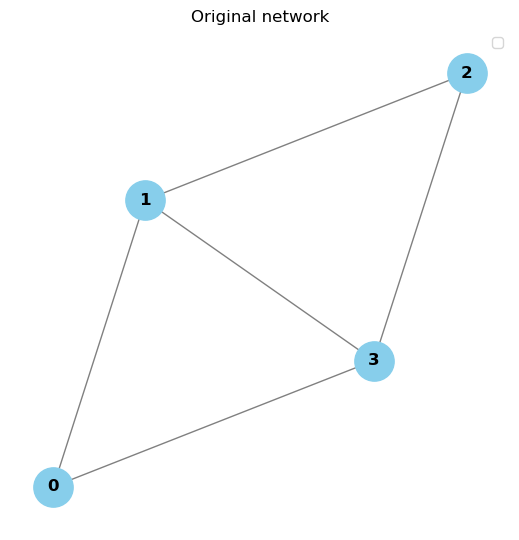

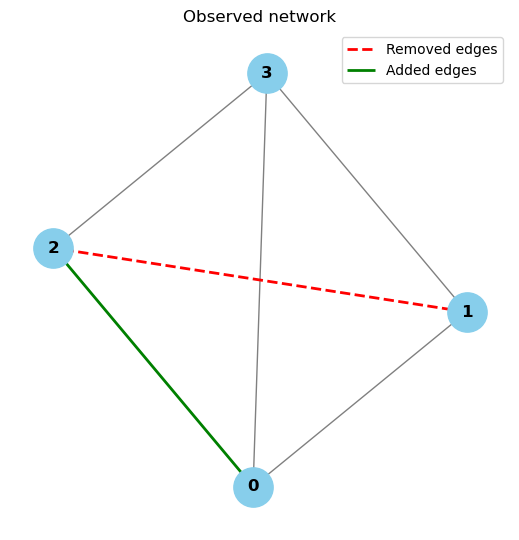

In [91]:
original_network = create_network()
plot_network(original_network, "Original network")

observed_network, removed_edges, added_edges = alterate_network(original_network)
plot_network(observed_network, "Observed network", removed_edges, added_edges)

_____________________________________________________________________

In [92]:
# Function to create a random partition of nodes
def create_random_partition(G, num_blocks=2):
    """ Randomly assigns each node to a group, ensuring at least two groups exist """
    partition = {}
    blocks_used = set()

    for node in G.nodes():
        block = random.randint(0, num_blocks-1)
        partition[node] = block
        blocks_used.add(block)

    # Ensure at least two groups exist
    if len(blocks_used) == 1:
        nodes = list(G.nodes())
        partition[nodes[0]] = 0
        partition[nodes[-1]] = 1

    return partition

# Function to compute the probability matrix Q of the blocks
def compute_Q(G, partition):
    """ Computes Q: probability that two nodes in groups (α, β) are connected """
    blocks_present = set(partition.values())  # Get existing blocks
    num_blocks = len(blocks_present)

    # Create a map from block -> index
    block_map = {block: i for i, block in enumerate(sorted(blocks_present))}
    
    # Initialize matrices
    Q = np.zeros((num_blocks, num_blocks))
    counts = np.zeros((num_blocks, num_blocks))

    for u, v in G.edges():
        group_u, group_v = block_map[partition[u]], block_map[partition[v]]
        Q[group_u, group_v] += 1
        Q[group_v, group_u] += 1  # Symmetric matrix

    # Normalize Q
    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                group_u, group_v = block_map[partition[u]], block_map[partition[v]]
                counts[group_u, group_v] += 1

    for i in range(num_blocks):
        for j in range(num_blocks):
            if counts[i, j] > 0:
                Q[i, j] /= counts[i, j]

    return Q



Step 2: Implementare Metropolis-Hastings

L'algoritmo di Metropolis-Hastings ci permette di esplorare diverse possibili partizioni della rete per trovare quelle più probabili.
Idea:

    Iniziamo con una partizione casuale.
    Proponiamo una modifica (spostiamo un nodo in un altro gruppo).
    Accettiamo o rifiutiamo la nuova partizione in base alla sua probabilità.
    Dopo molte iterazioni, otteniamo una stima accurata delle partizioni più probabili.

In [93]:


# Function to compute H(P), the "cost" of the partition
def compute_H(G, partition):
    """ Computes H(P): Lower H means a more probable partition """
    Q = compute_Q(G, partition)
    H = 0
    num_blocks = len(set(partition.values()))

    for i in range(num_blocks):
        for j in range(num_blocks):
            if Q[i, j] > 0:  # Avoid log(0)
                H += -np.log(Q[i, j] + 1e-6)  # Regularization

    return H

# Metropolis-Hastings algorithm to sample network partitions
def metropolis_hastings(G, num_blocks=2, iterations=10000):
    """ Runs Metropolis-Hastings to find the best partition """
    partition = create_random_partition(G, num_blocks)
    current_H = compute_H(G, partition)

    best_partitions = []
    best_H_values = []

    for _ in range(iterations):
        # Propose a new partition
        new_partition = partition.copy()
        chosen_node = np.random.choice(list(G.nodes))
        new_block = np.random.randint(0, num_blocks)
        new_partition[chosen_node] = new_block

        # Compute new H value
        new_H = compute_H(G, new_partition)
        delta_H = new_H - current_H

        # Accept the new partition with probability e^(-delta_H)
        if delta_H < 0 or np.random.rand() < np.exp(-delta_H):
            partition = new_partition
            current_H = new_H

            best_partitions.append(partition)
            best_H_values.append(current_H)

    return best_partitions[np.argmin(best_H_values)]  # Return the best partition found



Step 3: Calcolare la Reliability dei Link

Ora calcoliamo la probabilità che un link sia "vero", ovvero la reliability.
La formula dell'articolo è:
Rij=∑PlσiσjO+1rσiσj+2e−H(P)


Dove:

    lσiσjO​ è il numero di collegamenti osservati tra i gruppi dei nodi ii e jj.
    rσiσj​​ è il numero massimo possibile di collegamenti tra i gruppi.
    e−H(P) è il peso della partizione nella somma.

In [94]:
# Function to compute reliability of each link based on the optimal partition
def compute_reliability(G_obs, partition):
    """ Computes the reliability of each link based on the optimal partition """
    reliability = {}
    Q = compute_Q(G_obs, partition)

    for u, v in G_obs.edges():
        group_u, group_v = partition[u], partition[v]
        l_obs = G_obs.number_of_edges(u, v)
        r_max = G_obs.number_of_nodes()  # Maximum possible connections

        # Bayesian formula from the paper
        reliability[(u, v)] = (l_obs + 1) / (r_max + 2)

    return reliability

Reliability of observed links:
Link (0, 3): Reliability 0.3333
Link (0, 2): Reliability 0.3333
Link (1, 2): Reliability 0.3333
Link (1, 3): Reliability 0.3333
Link (2, 3): Reliability 0.3333


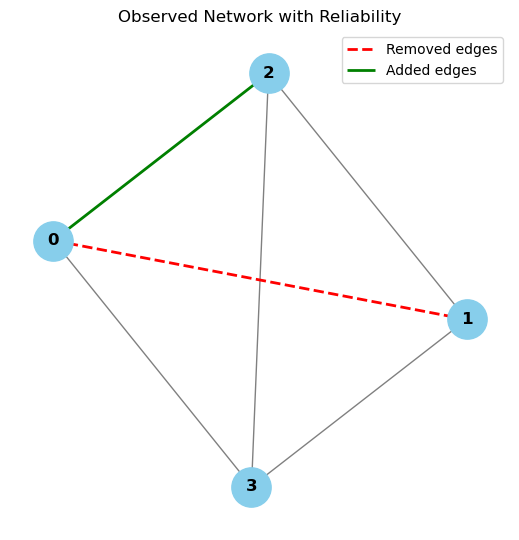

In [95]:
# MAIN: Putting everything together
G_real = create_network()
G_obs, removed_edges, added_edges = alterate_network(G_real, frac=0.3)

# Find the best partition with Metropolis-Hastings
optimal_partition = metropolis_hastings(G_obs, num_blocks=2, iterations=10000)

# Compute the reliability of the links
reliability = compute_reliability(G_obs, optimal_partition)

# Print the results
print("Reliability of observed links:")
for edge, score in sorted(reliability.items(), key=lambda x: x[1], reverse=True):
    print(f"Link {edge}: Reliability {score:.4f}")

# Plot the network with estimated probabilities
plot_network(G_obs, "Observed Network with Reliability", removed_edges, added_edges)

__________________________________________________________________________________________

La reliability (affidabilità) di un collegamento in una rete misura quanto è probabile che un determinato link esista davvero data la rete osservata. L'idea è che i dati sperimentali sulle reti possono contenere errori, quindi vogliamo stimare se un collegamento è affidabile o se potrebbe essere spurio (falso positivo) o mancante (falso negativo).  

Nel codice che ti ho fornito, la reliability di un collegamento (i,j)(i,j) è approssimata usando il numero di vicini comuni tra i nodi ii e jj.
Più nodi condividono connessi sia a ii che a jj, più è probabile che ii e jj siano effettivamente connessi.

Formula usata:
Reliability(i,j)=Numero di vicini comuni tra i e j


GUARDO SE QUESTA FORMULA VA BENE, CONTROLLO PAPER  

Nell’articolo di Guimerà e Sales-Pardo, invece di usare solo i vicini comuni, viene utilizzato un modello probabilistico basato su Metropolis-Hastings, che stima la vera reliability di un link considerando l’intera struttura della rete e un modello a blocchi stocastici.

In [96]:
# Compute reliability of the network
def compute_reliability(G, edges):
    scores= {}
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        scores[(u,v)] = common_neighbors
    return scores


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


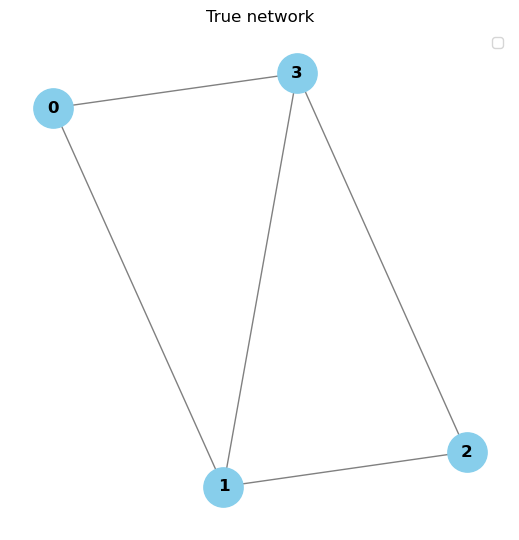

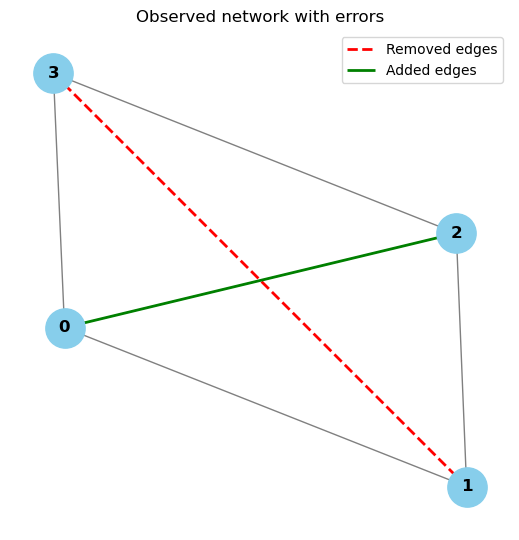

Reliability of the network:
Edge (0, 2): 2 common neighbors
Edge (0, 1): 1 common neighbors
Edge (0, 3): 1 common neighbors
Edge (1, 2): 1 common neighbors
Edge (2, 3): 1 common neighbors


In [97]:
G_true = create_network()
G_observed, removed_edges, added_edges= alterate_network(G_true, frac=0.3)

# Compute the reliability of the network
reliability = compute_reliability(G_observed, list(nx.edges(G_observed)))

# Plots
plot_network(G_true, "True network")
plot_network(G_observed, "Observed network with errors", removed_edges, added_edges)

print("Reliability of the network:")
for edge, score in sorted(reliability.items(), key= lambda x: x[1], reverse=True):
    print(f"Edge {edge}: {score} common neighbors")

4️⃣ Prossimi passi

🔹 Implementare Metropolis-Hastings per stimare la vera probabilità di un link, invece dei vicini comuni.    
    Riprodurre le curve della FIg.2  nel paper   
🔹 Estendere il codice a reti più grandi.  
🔹 Confrontare il metodo con altre tecniche (es. algoritmo di Clauset et al.)

Nell’articolo di Guimerà e Sales-Pardo, invece di usare solo i vicini comuni per calcolare la reliability, viene utilizzato un modello probabilistico basato su Metropolis-Hastings, che stima la vera reliability di un link considerando l’intera struttura della rete e un modello a blocchi stocastici.